# Lecture 23: Markov Decision Processes and Value Iteration
***

        
<img src="figs/robot_banner.png",width=1000,height=50>        

In [53]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

msize = 200
myfigsize=(12,6)

mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}

class GridWorld:
    def __init__(self, nx, ny, terminal_states, terminal_values, dead_states, reward=-5, discount=1):
        self.terminal_states=terminal_states
        self.dead_states=dead_states
        self.R = reward 
        self.gamma = discount
        self.V = np.zeros((nx,ny))
        for s, val in zip(terminal_states, terminal_values):
            self.V[s] = val 
        self.grid = [(ii,jj) for ii in range(nx) for jj in range(ny) if (ii,jj) not in terminal_states and (ii,jj) not in dead_states]
        self.moves = {}
        for s in self.grid:
            self.moves[s] = self.get_moves(s)
                
    def get_moves(self, s=None):
        directions = [(0,1), (0,-1), (1,0), (-1,0)] # U, D, R, L
        maybe_moves = [tuple(p+d for p, d in zip(s, d)) for d in directions]
        actual_moves = [] 
        for move in maybe_moves:
            if move in self.grid or move in self.terminal_states:
                actual_moves.append(move)
            else:
                actual_moves.append(s)
        return actual_moves
    
    def value_iteration(self, eps=1e-5, max_iter=None, diagnostic=False):
        Ps = [[.8, .0, .1, .1], [.0, .8, .1, .1], [.1, .1, .8, .0], [.1, .1, .0, .8]]
        tol = eps * np.max(self.V)
        delta = np.inf 
        iters = 0
        old_policy = [self.policy(s) for s in self.grid]
        while delta > tol: 
            iters += 1
            if max_iter and iters >= max_iter:
                break
            Vprime = self.V.copy()
            delta = 0 
            for s in self.grid:
                utilities = [self.V[m] for m in self.moves[s]]
                actions = [np.dot(P, utilities) for P in Ps]
                Vprime[s] = self.R + self.gamma * np.max(actions)
                diff = np.abs(self.V[s]-Vprime[s])
                delta = diff if diff > delta else delta 
            self.V = Vprime
            if diagnostic:
                new_policy = [self.policy(s) for s in self.grid]
                pchange = sum([new != old for new, old in zip(new_policy, old_policy)])
                old_policy = new_policy
                print "{:d} policy changes on iteration {:d}".format(pchange,iters)
            
        print "\nValue Iteration converged in {:d} iterations".format(iters)
            
    def policy(self, s):
        Ps = [[.8, .0, .1, .1], [.0, .8, .1, .1], [.1, .1, .8, .0], [.1, .1, .0, .8]]
        utilities = [self.V[m] for m in self.moves[s]]
        actions = [np.dot(P, utilities) for P in Ps]
        return np.argmax(actions)
        
    
    def draw_utility(self):
        
        # Get board limits 
        mxx = max([ii for ii, jj in self.grid])
        mxy = max([jj for ii, jj in self.grid])
        
        # Draw board 
        fig = plt.figure(figsize=(2*mxx,2*mxy))
        ax = fig.add_subplot(111, aspect='equal')
        
        for sq in self.grid:
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=1, facecolor="black", alpha=0.01))
        for sq in self.terminal_states:
            color = mycolors["red"] if self.V[sq] < 0 else mycolors["green"]
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=1, facecolor=color, alpha=0.5))
        for s in self.dead_states:
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, facecolor="black", alpha=0.7))
            
        for sq in self.grid:
            ax.text(sq[0]+.2,sq[1]+.4, "{:+3.3f}".format(self.V[sq]), fontsize=16)
        for sq in self.terminal_states:
            ax.text(sq[0]+.2,sq[1]+.4, "{:+3.3f}".format(self.V[sq]), fontsize=16)
        
        # Make pretty     
        ax.set_xlim(-.1,mxx+1.1)
        ax.set_ylim(-.1,mxy+1.1)
        plt.xticks([], fontsize=16)
        plt.yticks([], fontsize=16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.tight_layout()
        
        
    def draw_policy(self):
        
        # Get board limits 
        mxx = max([ii for ii, jj in self.grid])
        mxy = max([jj for ii, jj in self.grid])
        
        # Draw board 
        fig = plt.figure(figsize=(2*mxx,2*mxy))
        ax = fig.add_subplot(111, aspect='equal')
        
        for s in self.grid:
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, facecolor="black", alpha=0.01))
        for s in self.terminal_states:
            color = mycolors["red"] if self.V[s] < 0 else mycolors["green"]
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, facecolor=color, alpha=0.5))
        for s in self.dead_states:
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(s, 1, 1, lw=1, facecolor="black", alpha=0.7))
            
        for s in self.grid:
            action = self.policy(s)
            if action == 0:
                ax.arrow(s[0]+.5, s[1]+.25, 0, 0.35, head_width=0.15, head_length=0.15, fc='k', ec='k')
            if action == 1:
                ax.arrow(s[0]+.5, s[1]+.75, 0, -0.35, head_width=0.15, head_length=0.15, fc='k', ec='k')
            if action == 2:
                ax.arrow(s[0]+.25, s[1]+.5, 0.35, 0, head_width=0.15, head_length=0.15, fc='k', ec='k')
            if action == 3:
                ax.arrow(s[0]+.75, s[1]+.5, -0.35, 0, head_width=0.15, head_length=0.15, fc='k', ec='k')
        for s in self.terminal_states:
            ax.text(s[0]+.2,s[1]+.4, "{:+3.3f}".format(self.V[s]), fontsize=16)
        
        # Make pretty     
        ax.set_xlim(-.1,mxx+1.1)
        ax.set_ylim(-.1,mxy+1.1)
        plt.xticks([], fontsize=16)
        plt.yticks([], fontsize=16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.tight_layout()



Value Iteration converged in 1 iterations


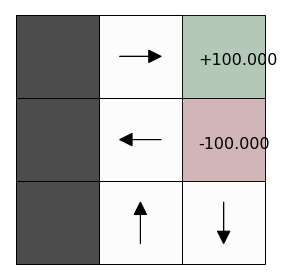

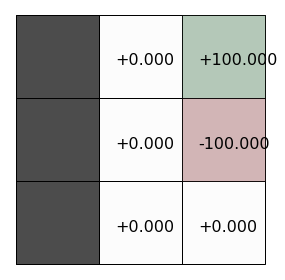

In [63]:
nx, ny = 3, 3
terminal_states = [(2,2), (2,1)]
terminal_values = [100, -100]
dead_states = [(0,0), (0,1), (0,2)]
non_terminal_reward = -10
discount = 0.50
world = GridWorld(nx, ny, terminal_states, terminal_values, dead_states, discount=discount, reward=non_terminal_reward)
world.value_iteration(diagnostic=True, max_iter=1)
world.draw_policy()
world.draw_utility()

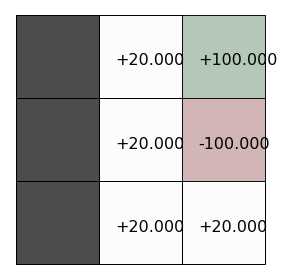

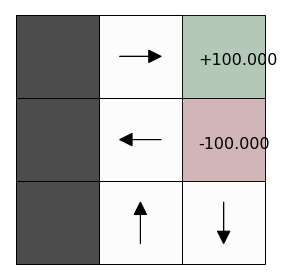

In [69]:
world.V = 20*np.ones((3,3))
world.V[2,1] = -100
world.V[2,2] = +100
world.draw_utility()
world.draw_policy()